In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

# Carga de Union
df = pd.read_csv("union_datasets.csv")

In [7]:
df.head()

,FECHA,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,UTILH00,...,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21,ANNO,MES,DIA,DIASEM
0,2015-01-01,0.0,0.0,0.0,720787.40,1250876.4,321124.25,0.0,0.0,0.000028,...,0.058280,0.493552,0.507370,0.060543,0.000026,0.000024,2015,1,1,3
1,2015-01-02,0.0,0.0,0.0,706537.90,1200328.0,240638.28,0.0,0.0,0.000020,...,0.069688,0.533332,0.482276,0.045711,0.000026,0.000025,2015,1,2,4
2,2015-01-03,0.0,0.0,0.0,689722.75,1212699.0,308298.53,0.0,0.0,0.000025,...,0.064860,0.512002,0.497585,0.059138,0.000028,0.000023,2015,1,3,5
3,2015-01-04,0.0,0.0,0.0,709174.06,1227577.8,340632.30,0.0,0.0,0.000023,...,0.065306,0.518908,0.511468,0.061739,0.000028,0.000026,2015,1,4,6
4,2015-01-05,0.0,0.0,0.0,717798.06,1239895.0,336642.70,0.0,0.0,0.000021,...,0.052947,0.424561,0.434292,0.044874,0.000029,0.000020,2015,1,5,0


## 1. Linear Regression

In [8]:
INPUTS = ['IRRADH00','IRRADH03','IRRADH06','IRRADH09','IRRADH12','IRRADH15','IRRADH18','IRRADH21','ANNO','MES']
OUTPUTS = ['UTILH00','UTILH03','UTILH06','UTILH09','UTILH12','UTILH15','UTILH18','UTILH21']
X = df[INPUTS]

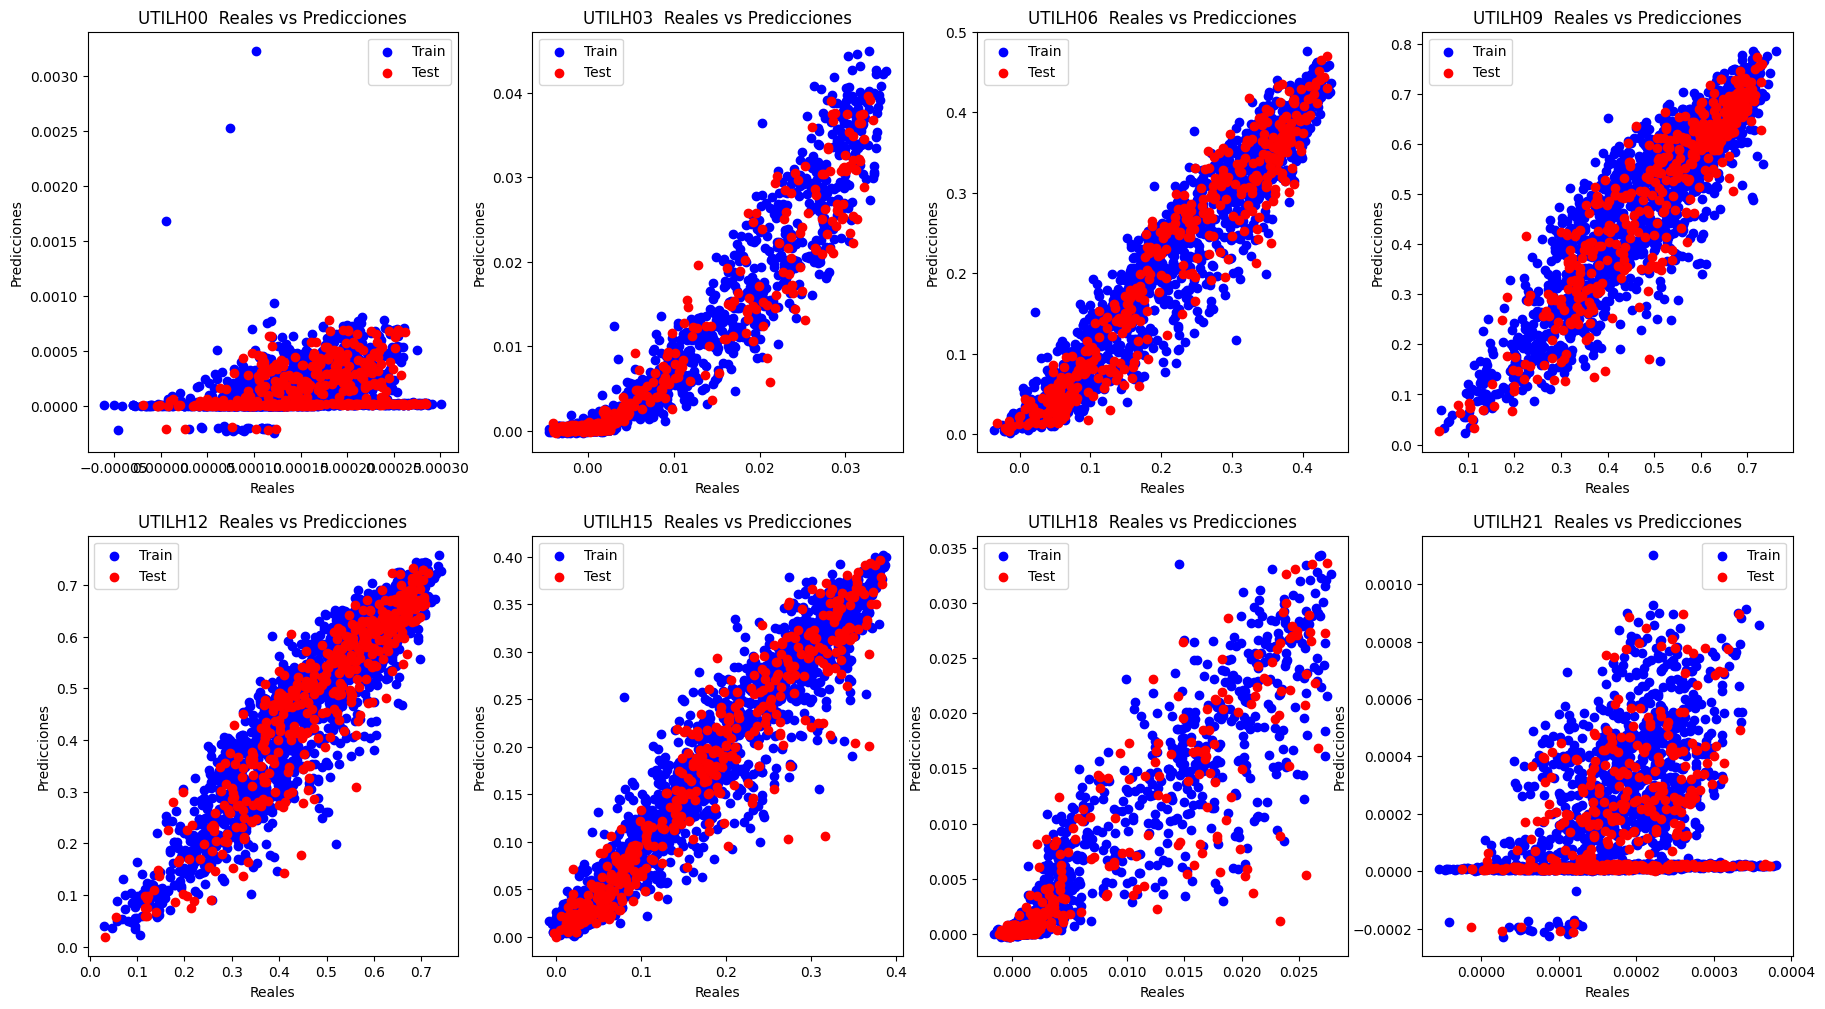

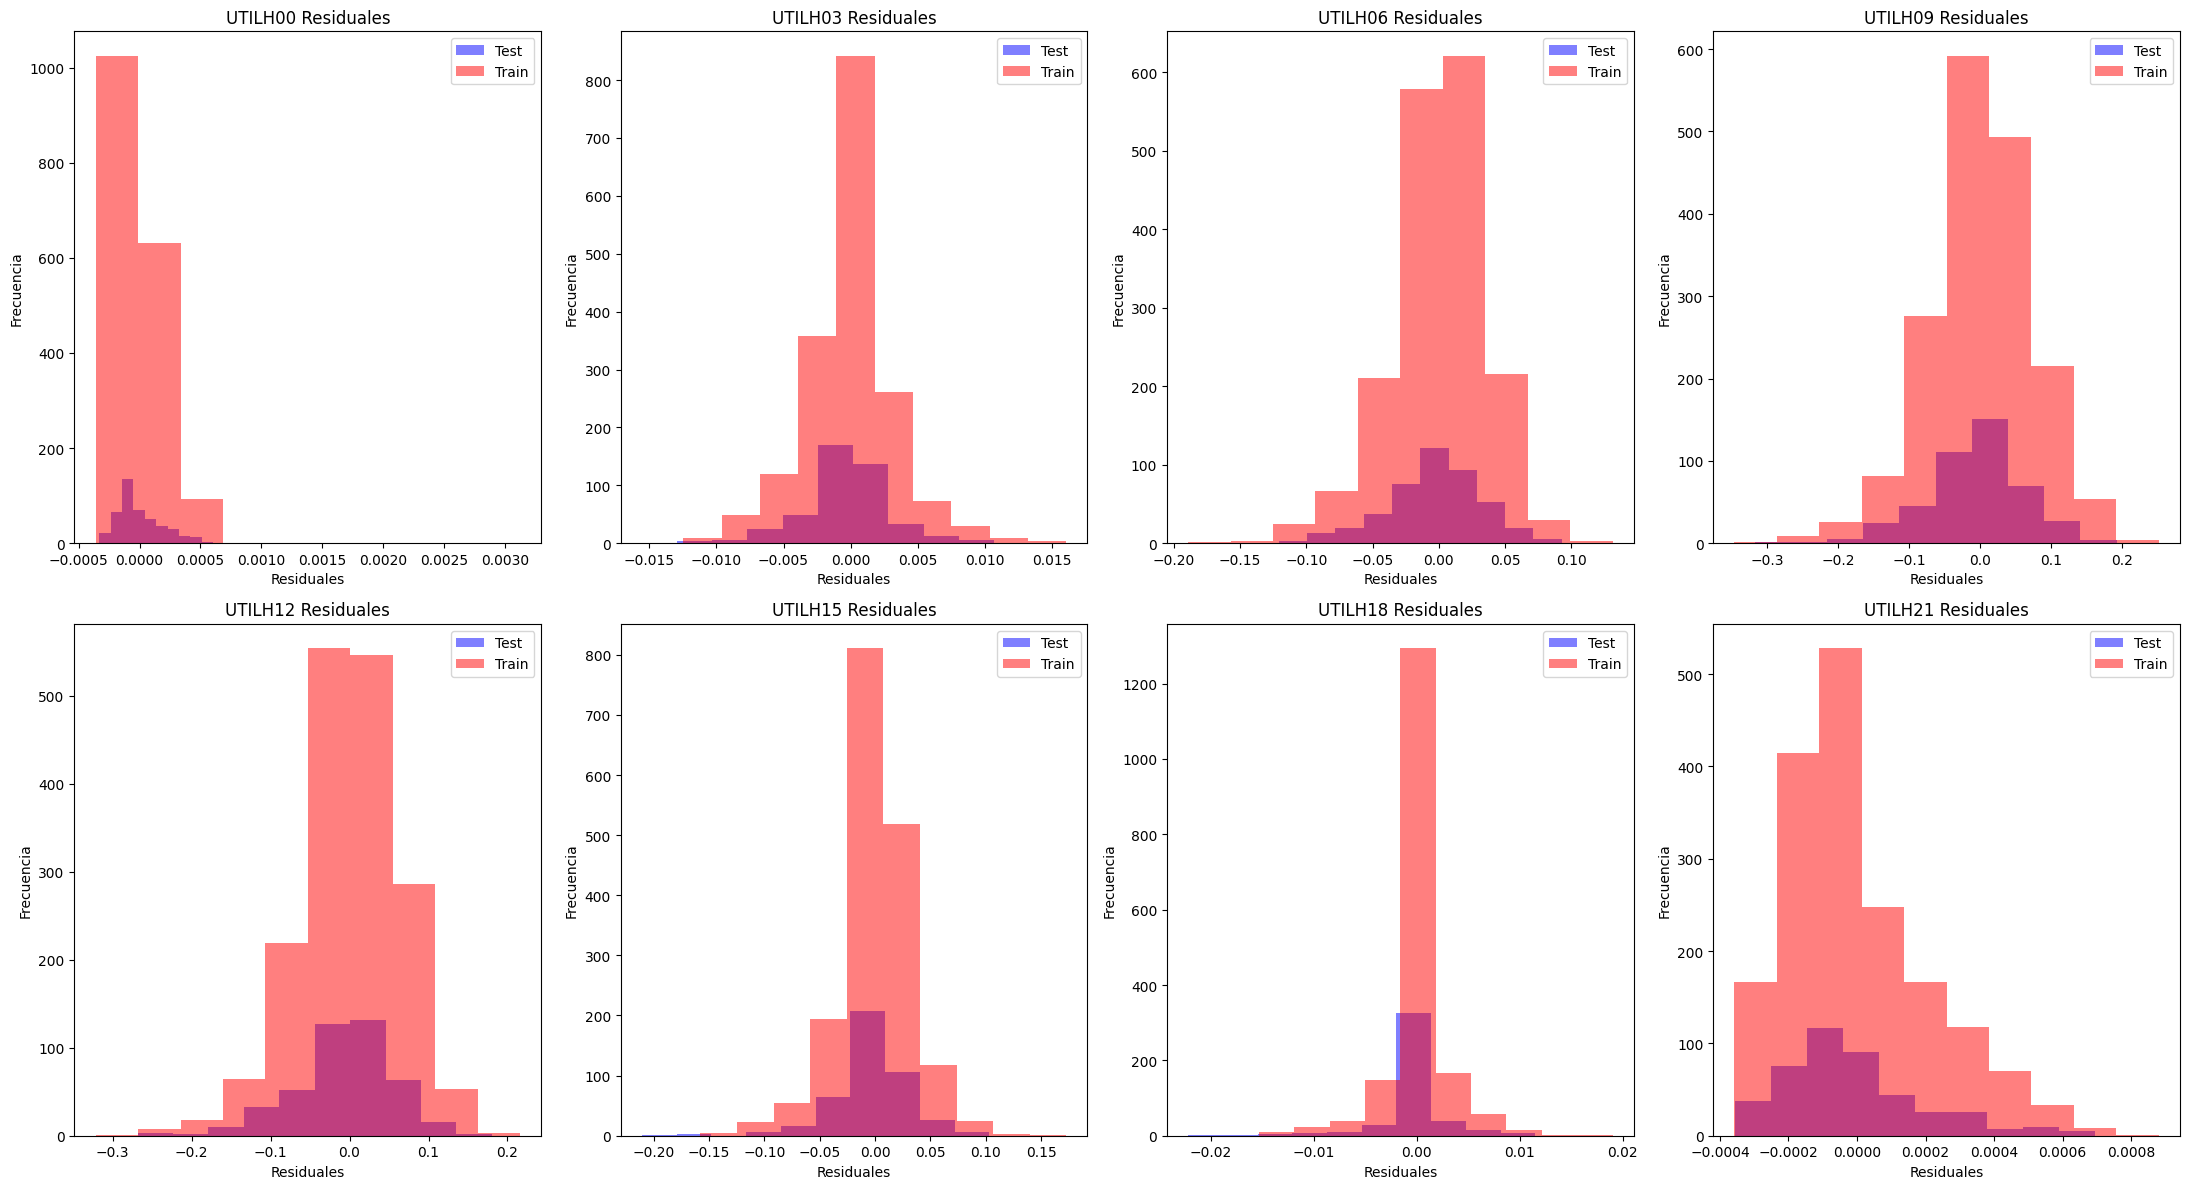

,OUTPUT,RMSE_train,R_squared_train,RMSE_test,R_squared_test,High_pvalue_vars
0,UTILH00,0.000203,0.090005,0.000186,0.110781,"[IRRADH09, MES]"
1,UTILH03,0.003300,0.914603,0.003283,0.912082,[]
2,UTILH06,0.035591,0.928340,0.036089,0.930031,[MES]
3,UTILH09,0.072119,0.822457,0.068303,0.846770,[IRRADH18]
4,UTILH12,0.063567,0.848166,0.064253,0.850412,"[IRRADH15, IRRADH18]"
5,UTILH15,0.032452,0.921455,0.035276,0.906678,"[IRRADH06, IRRADH18]"
6,UTILH18,0.002827,0.879119,0.003493,0.815683,[IRRADH12]
7,UTILH21,0.000207,0.136446,0.000202,0.096503,"[IRRADH12, IRRADH15]"


In [17]:
#PREGUNTAR SI PARA CADA HORA ES NECESARIO TENER EN CUENTA TODAS LAS VARIABLES DE IRRADIACIÓN
results_df_lr = pd.DataFrame(columns=['OUTPUT', 'RMSE_train', 'R_squared_train', 'RMSE_test', 'R_squared_test', 'High_pvalue_vars'])

# Create subplots
fig2, axs2 = plt.subplots(2, 4, figsize=(22, 12))
fig, axs = plt.subplots(2, 4, figsize=(22, 12))
i=0
for OUTPUT in OUTPUTS:
    hora = OUTPUT[-2:]
    y = df[OUTPUT]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,  # percentage of test data
                                                        random_state=1234)   # Preserves distribution of y

    # Fit the linear regression model using statsmodels
    X_train_with_intercept = sm.add_constant(X_train)  # Add constant for the intercept
    model = sm.OLS(y_train, X_train_with_intercept)
    results = model.fit()
    # Get summary statistics
    summary = results.summary()
    # Extract p-values for input variables
    p_values = summary.tables[1].data[3:]  # Skip header rows
    p_values = pd.DataFrame(p_values, columns=['Variable', 'Coef', 'Std.Err', 't', 'P>|t|', '0.025','0.975'])
    p_values['P>|t|'] = p_values['P>|t|'].astype(float)
    # Filter variables with p-value > 0.05
    high_pvalue_vars = p_values[p_values['P>|t|'] > 0.05]['Variable'].tolist()

    # Predict on the training set
    y_train_pred = results.predict(X_train_with_intercept)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # Calculate R-squared
    r2_train = r2_score(y_train, y_train_pred)

    # Predict on the test set
    y_test_pred = results.predict(sm.add_constant(X_test))
    # Calculate RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # Calculate R-squared
    r2_test = r2_score(y_test, y_test_pred)

    # Append results to DataFrame
    results_df_lr = results_df_lr.append({'OUTPUT': OUTPUT,
                                    'RMSE_train': rmse_train,
                                    'R_squared_train': r2_train,
                                    'RMSE_test': rmse_test,
                                    'R_squared_test': r2_test,
                                    'High_pvalue_vars': high_pvalue_vars}, ignore_index=True)

    row_index = i // 4
    col_index = i % 4
    # Plotting
    axs2[row_index, col_index].scatter(y_train_pred, y_train, color='blue', label='Train')
    axs2[row_index, col_index].scatter(y_test_pred, y_test, color='red', label='Test')
    axs2[row_index, col_index].set_title(f'{OUTPUT}  Reales vs Predicciones')
    axs2[row_index, col_index].set_xlabel('Reales')
    axs2[row_index, col_index].set_ylabel('Predicciones')
    axs2[row_index, col_index].legend()

       # Calculate residuals
    residuals_test = y_test - y_test_pred
    residuals_train = y_train - y_train_pred
    # Plot residuals
    axs[row_index, col_index].hist(residuals_test, color='blue', alpha=0.5, label='Test')
    axs[row_index, col_index].hist(residuals_train, color='red', alpha=0.5, label='Train')
    axs[row_index, col_index].set_title(f"{OUTPUT} Residuales")
    axs[row_index, col_index].set_xlabel('Residuales')
    axs[row_index, col_index].set_ylabel('Frecuencia')
    axs[row_index, col_index].legend()
    i+=1

# Print the results DataFrame
plt.tight_layout()
plt.show()

results_df_lr.head(8)


Comentarios de los plots:
- Predicciones bastante buenas para las horas de 06 a 15. Se aprecia un poco más de dispersión en las 18h y 03 horas. Los modelos de 21 y 00 horas son malos, hay varias predicciones a 0 o incluso negativas, cuando no puede ser negativo el valor.
- Residuales distribucion para las horas centrales, menos para las 21 y las 00 horas especialmente se aprecia que hay un claro sesgo a la derecha. Se debe seguramente a que son 2 modelos con un R2 bastante más bajo, debido a los bajos niveles de irradiación recibidos.
- No se aprecian diferencias notables entre residuales en train y test. En principio no parece haber overfitting.

## 2. Bagged Trees

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


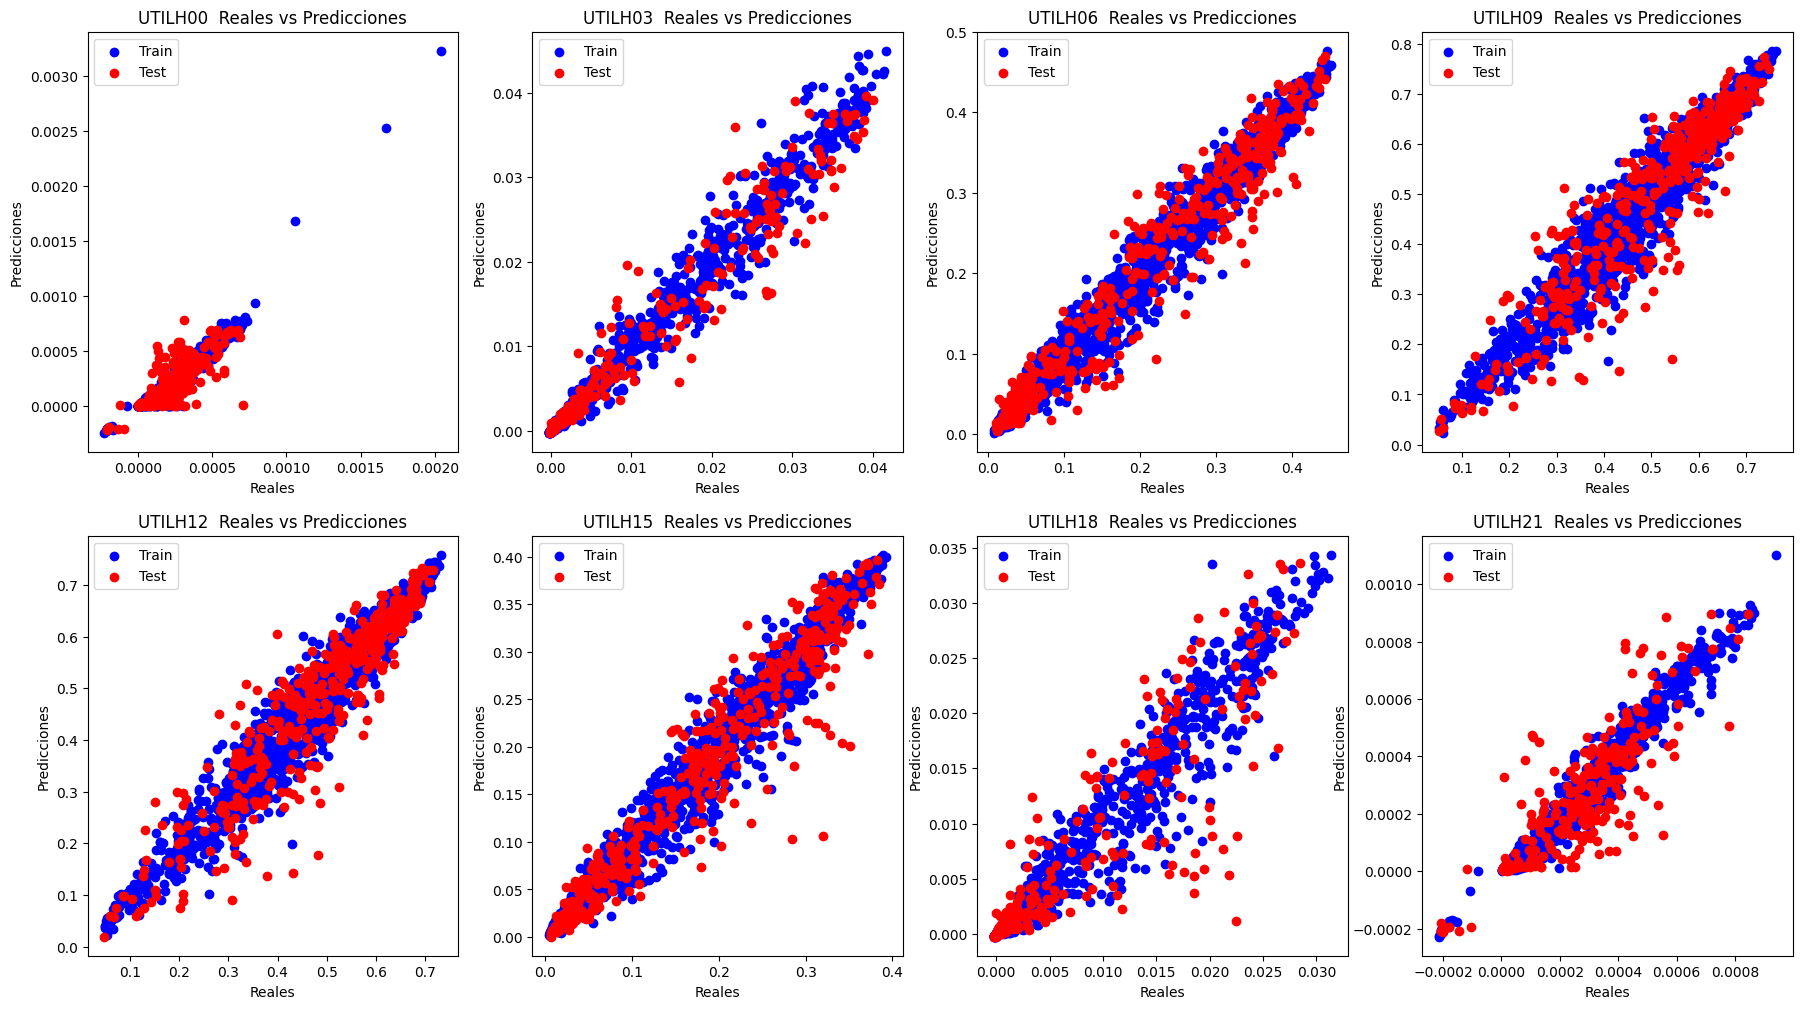

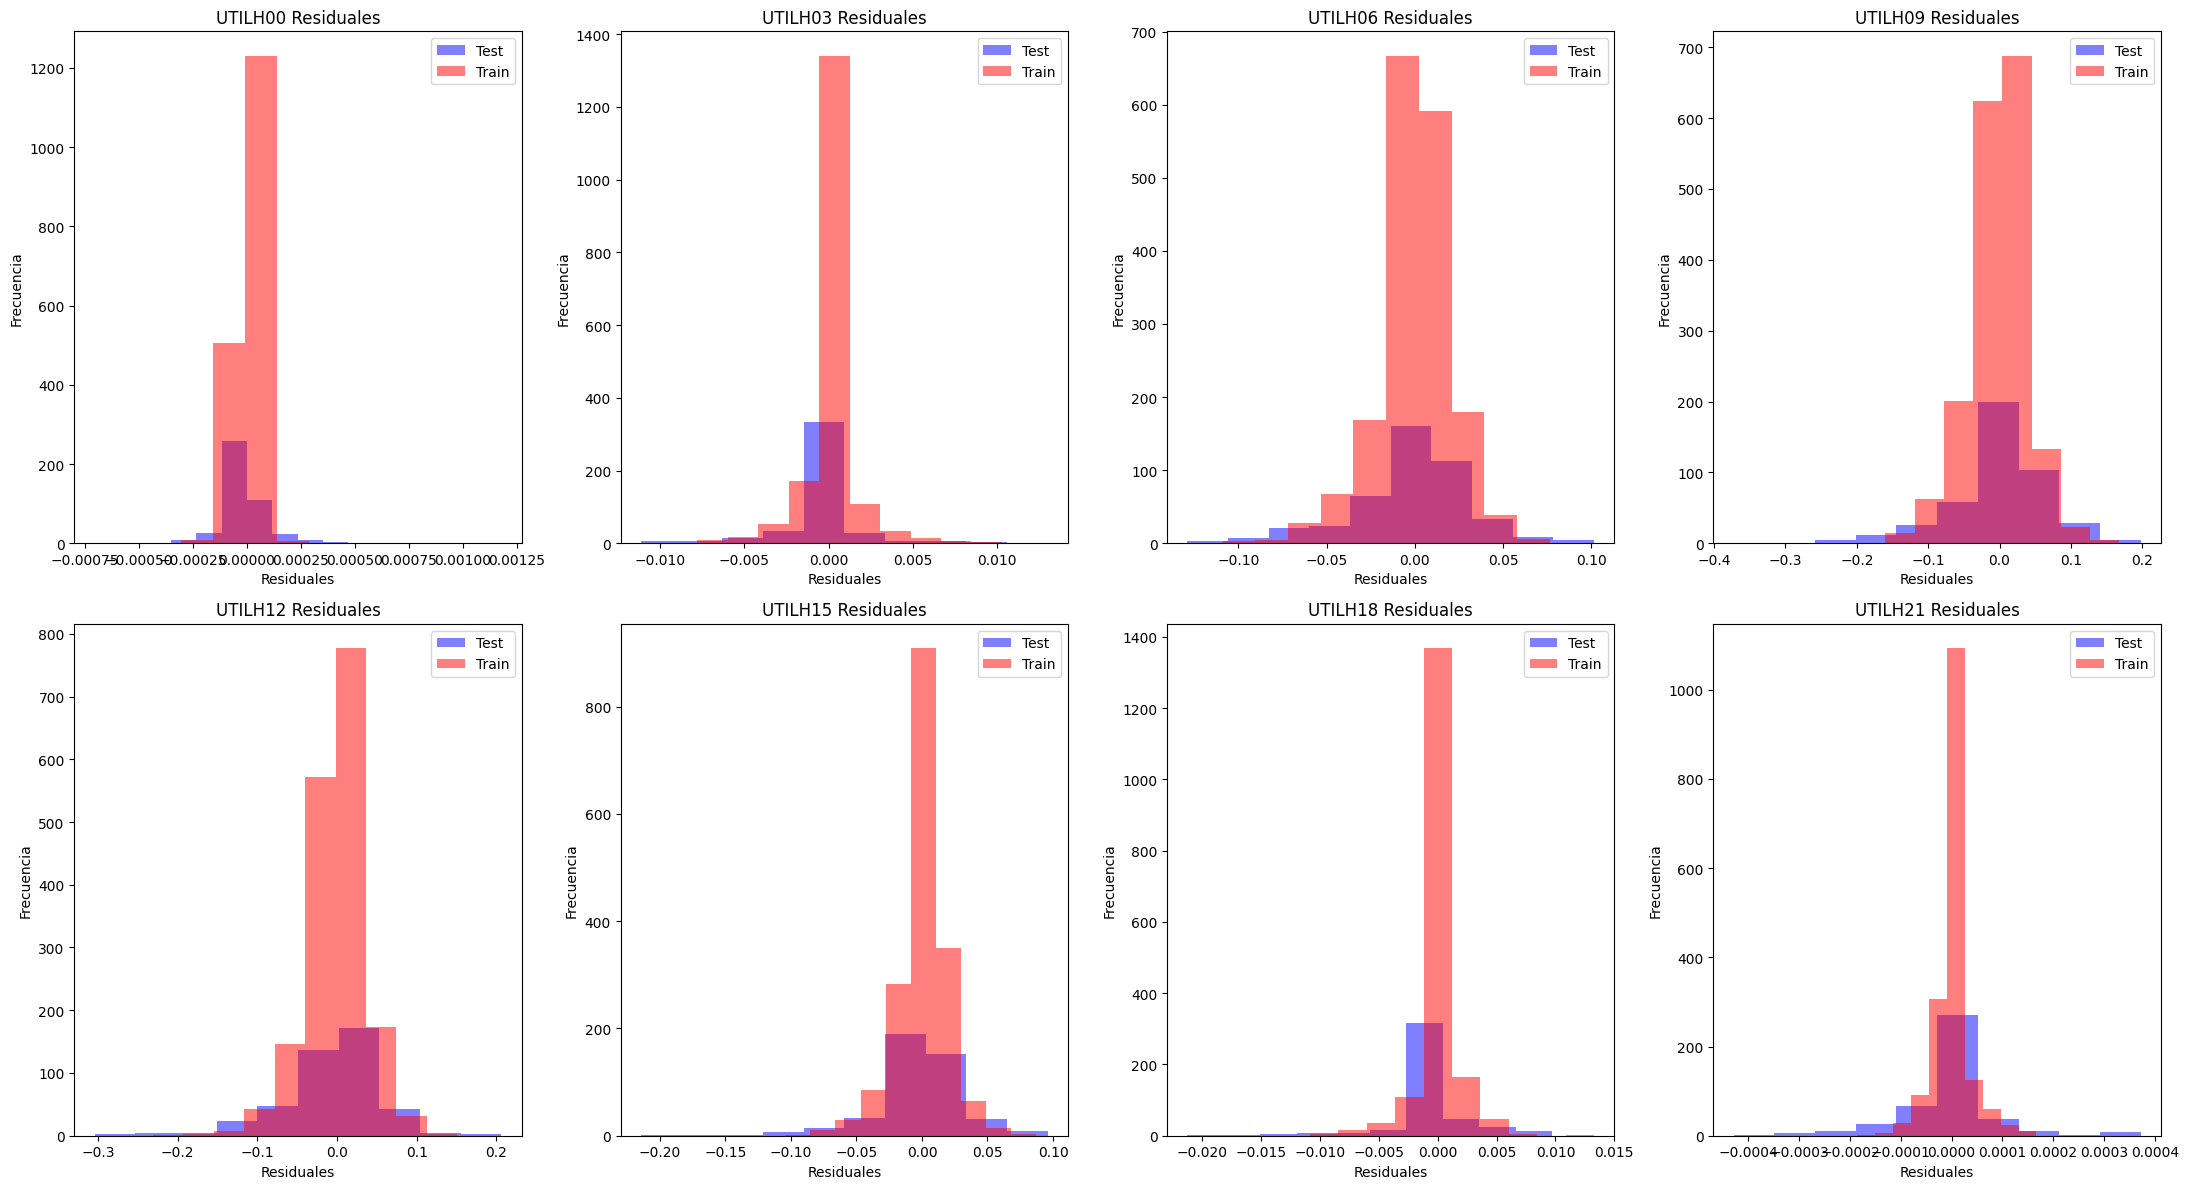

In [18]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}
# Create subplots
fig2, axs2 = plt.subplots(2, 4, figsize=(22, 12))
fig, axs = plt.subplots(2, 4, figsize=(22, 12))
i=0
results_df_bagged = pd.DataFrame(columns=['OUTPUT', 'RMSE_train', 'R_squared_train', 'RMSE_test', 'R_squared_test', 'Best_Params'])

for OUTPUT in OUTPUTS:

    y = df[OUTPUT]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,  # percentage of test data
                                                        random_state=1234)   # Preserves distribution of y
    base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeRegressor( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=999))]) 

    bagged = BaggingRegressor(base_estimator=None, random_state=1234)

    grid_search = GridSearchCV(estimator=bagged, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_bagged = grid_search.best_estimator_

    # Predict on the training set
    y_train_pred = best_bagged.predict(X_train)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # Calculate R-squared
    r2_train = r2_score(y_train, y_train_pred)

    # Predict on the test set
    y_test_pred = best_bagged.predict(X_test)
    # Calculate RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # Calculate R-squared
    r2_test = r2_score(y_test, y_test_pred)

    # Append results to DataFrame
    results_df_bagged = results_df_bagged.append({'OUTPUT': OUTPUT,
                                                  'RMSE_train': rmse_train,
                                                  'R_squared_train': r2_train,
                                                  'RMSE_test': rmse_test,
                                                  'R_squared_test': r2_test,
                                                  'Best_Params': grid_search.best_params_}, ignore_index=True)
    row_index = i // 4
    col_index = i % 4
    # Plotting
    axs2[row_index, col_index].scatter(y_train_pred, y_train, color='blue', label='Train')
    axs2[row_index, col_index].scatter(y_test_pred, y_test, color='red', label='Test')
    axs2[row_index, col_index].set_title(f'{OUTPUT}  Reales vs Predicciones')
    axs2[row_index, col_index].set_xlabel('Reales')
    axs2[row_index, col_index].set_ylabel('Predicciones')
    axs2[row_index, col_index].legend()

       # Calculate residuals
    residuals_test = y_test - y_test_pred
    residuals_train = y_train - y_train_pred
    # Plot residuals
    axs[row_index, col_index].hist(residuals_test, color='blue', alpha=0.5, label='Test')
    axs[row_index, col_index].hist(residuals_train, color='red', alpha=0.5, label='Train')
    axs[row_index, col_index].set_title(f"{OUTPUT} Residuales")
    axs[row_index, col_index].set_xlabel('Residuales')
    axs[row_index, col_index].set_ylabel('Frecuencia')
    axs[row_index, col_index].legend()
    i+=1

# Print the results DataFrame
plt.tight_layout()
plt.show()



In [33]:
results_df_bagged.head(8)

,OUTPUT,RMSE_train,R_squared_train,RMSE_test,R_squared_test,Best_Params
0,UTILH00,0.000051,0.941316,0.000101,0.738664,"{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}"
1,UTILH03,0.001427,0.984039,0.002423,0.952094,"{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}"
2,UTILH06,0.020635,0.975912,0.033344,0.940267,"{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 300}"
3,UTILH09,0.040631,0.943646,0.067582,0.849989,"{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 300}"
4,UTILH12,0.035820,0.951788,0.062384,0.858985,"{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 300}"
5,UTILH15,0.019443,0.971806,0.034115,0.912722,"{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 300}"
6,UTILH18,0.001705,0.956063,0.003366,0.828761,"{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}"
7,UTILH21,0.000035,0.975294,0.000095,0.799697,"{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}"


## 3. Random Forests

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits


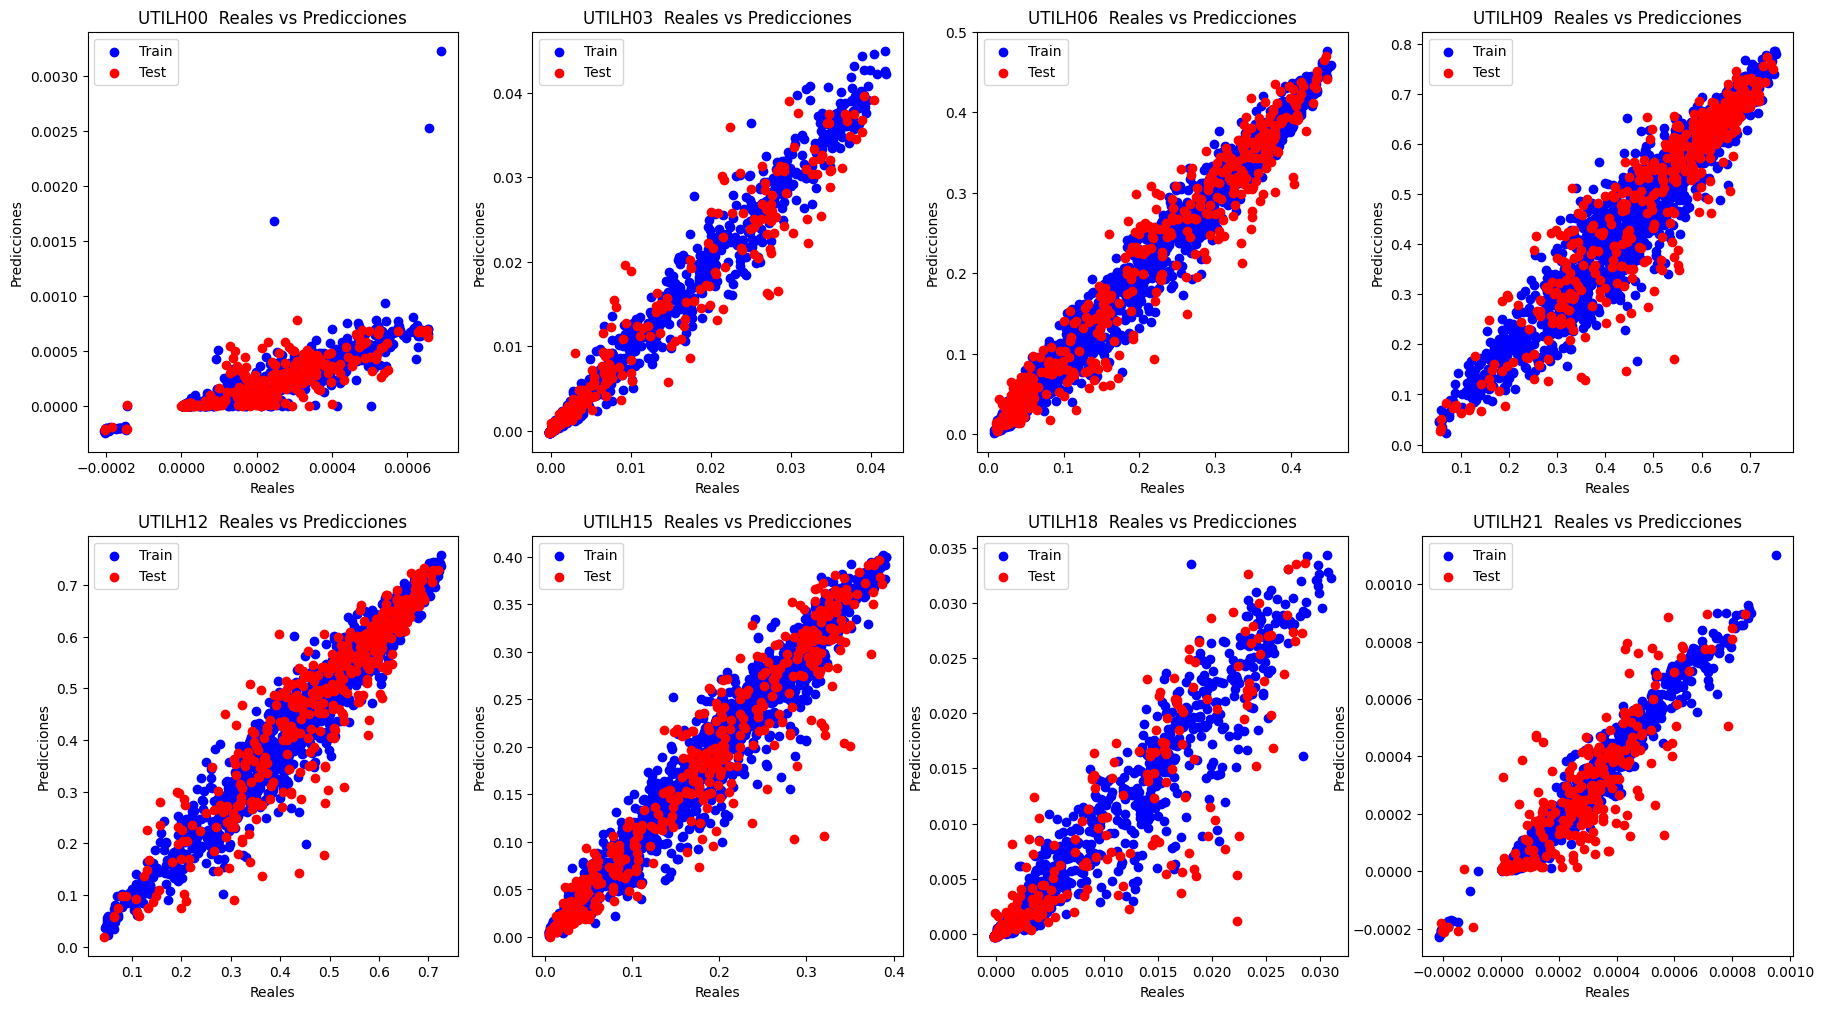

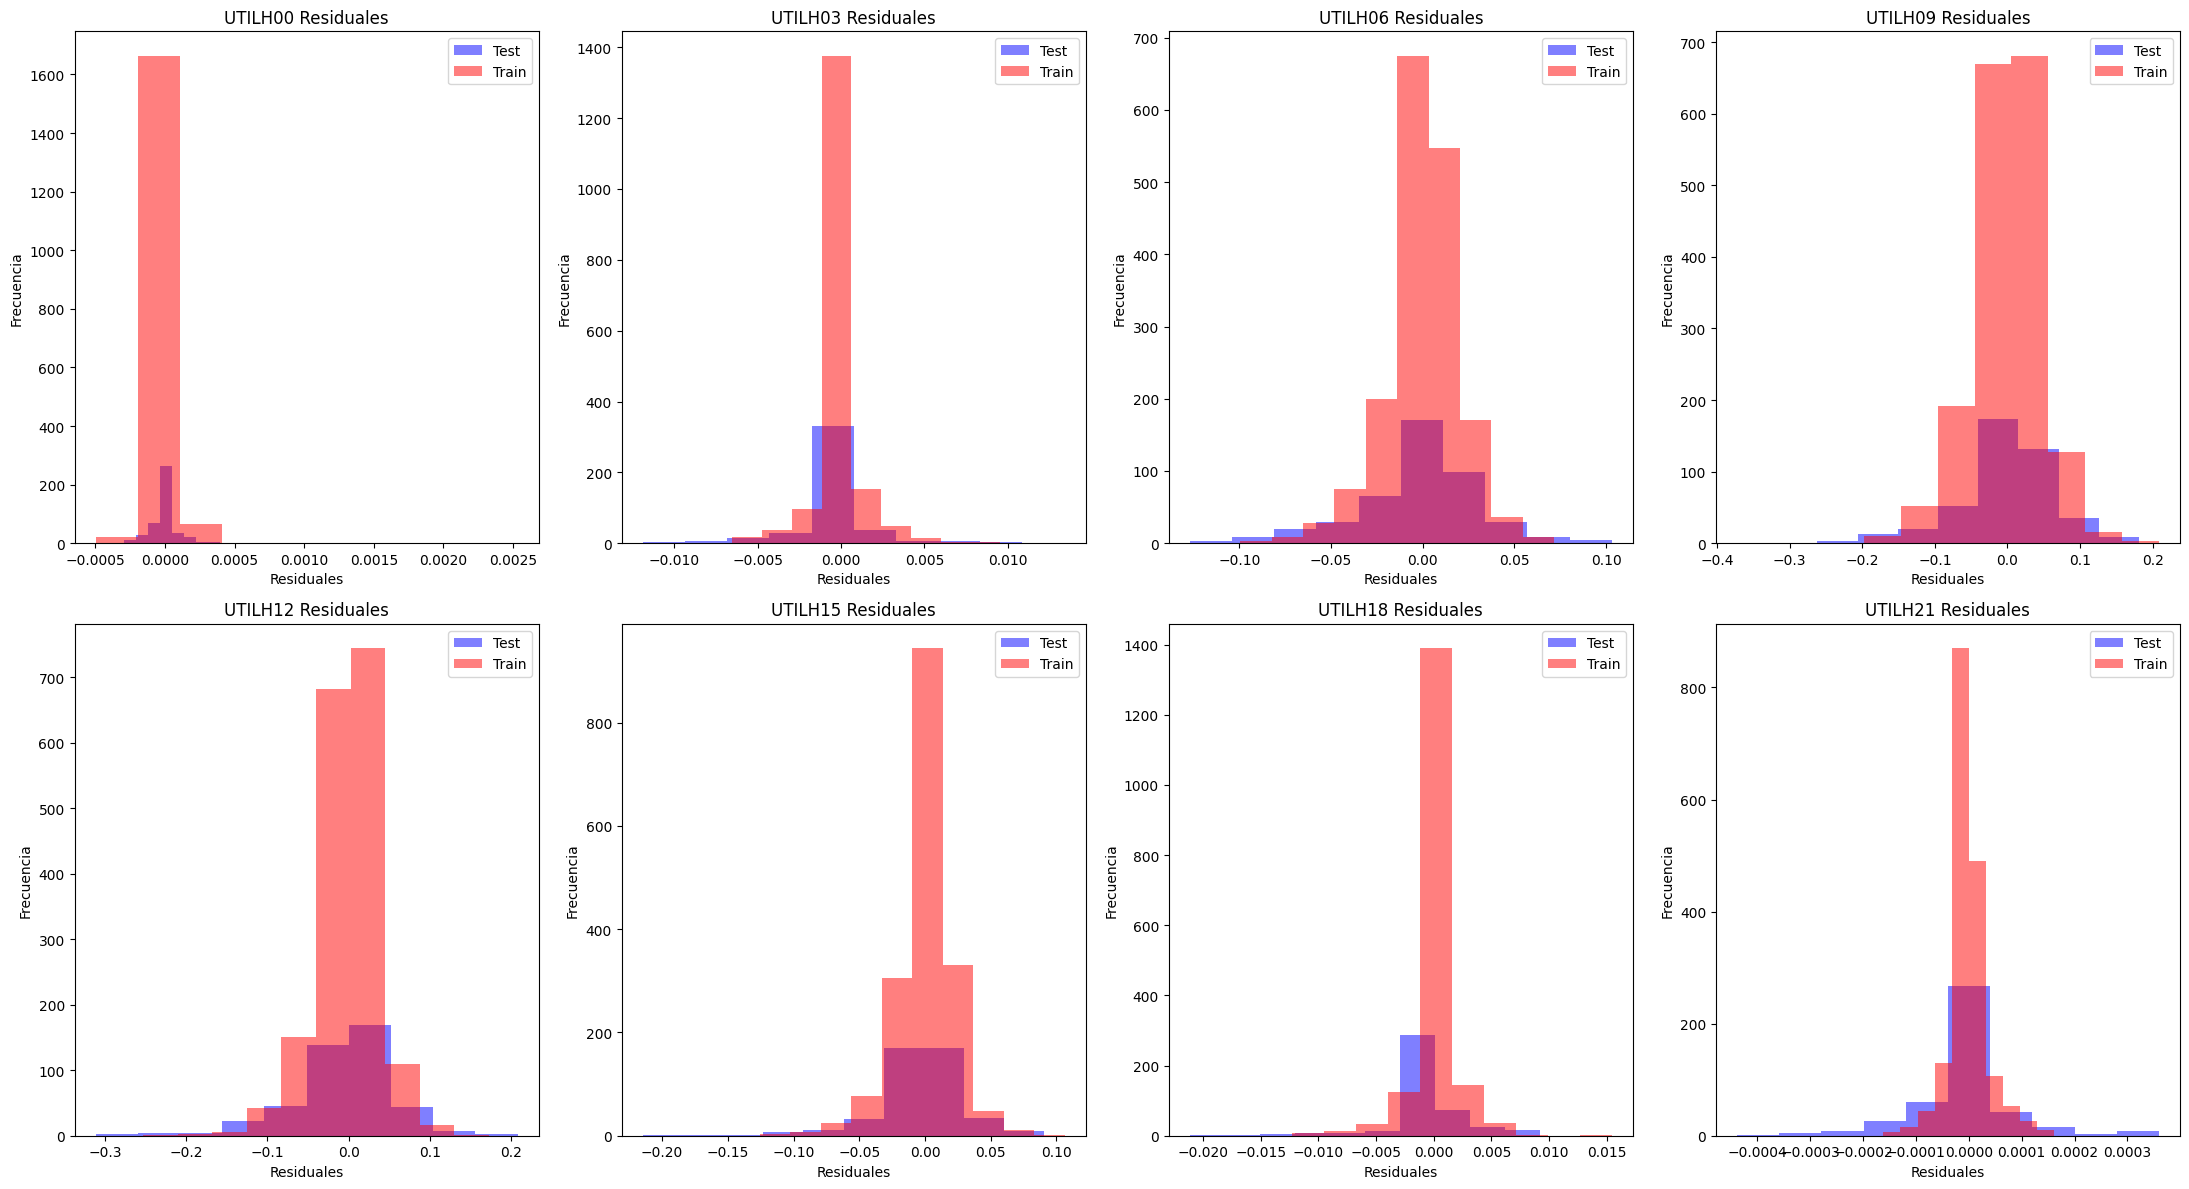

In [19]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Create subplots
fig2, axs2 = plt.subplots(2, 4, figsize=(22, 12))
fig, axs = plt.subplots(2, 4, figsize=(22, 12))
i=0

# Create an empty DataFrame to store results
results_df_rf_tuned = pd.DataFrame(columns=['OUTPUT', 'RMSE_train', 'R_squared_train', 'RMSE_test', 'R_squared_test', 'Best_Params'])

for OUTPUT in OUTPUTS:

    y = df[OUTPUT]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,  # percentage of test data
                                                        random_state=1234)   # Preserves distribution of y

    # Create Random Forest Regressor
    rf = RandomForestRegressor(random_state=1234)

    # Perform Grid Search to find best parameters
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_rf = grid_search.best_estimator_

    # Predict on the training set
    y_train_pred = best_rf.predict(X_train)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # Calculate R-squared
    r2_train = r2_score(y_train, y_train_pred)

    # Predict on the test set
    y_test_pred = best_rf.predict(X_test)
    # Calculate RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # Calculate R-squared
    r2_test = r2_score(y_test, y_test_pred)

    # Append results to DataFrame
    results_df_rf_tuned = results_df_rf_tuned.append({'OUTPUT': OUTPUT,
                                          'RMSE_train': rmse_train,
                                          'R_squared_train': r2_train,
                                          'RMSE_test': rmse_test,
                                          'R_squared_test': r2_test,
                                          'Best_Params': grid_search.best_params_}, ignore_index=True)
    row_index = i // 4
    col_index = i % 4
    # Plotting
    axs2[row_index, col_index].scatter(y_train_pred, y_train, color='blue', label='Train')
    axs2[row_index, col_index].scatter(y_test_pred, y_test, color='red', label='Test')
    axs2[row_index, col_index].set_title(f'{OUTPUT}  Reales vs Predicciones')
    axs2[row_index, col_index].set_xlabel('Reales')
    axs2[row_index, col_index].set_ylabel('Predicciones')
    axs2[row_index, col_index].legend()

       # Calculate residuals
    residuals_test = y_test - y_test_pred
    residuals_train = y_train - y_train_pred
    # Plot residuals
    axs[row_index, col_index].hist(residuals_test, color='blue', alpha=0.5, label='Test')
    axs[row_index, col_index].hist(residuals_train, color='red', alpha=0.5, label='Train')
    axs[row_index, col_index].set_title(f"{OUTPUT} Residuales")
    axs[row_index, col_index].set_xlabel('Residuales')
    axs[row_index, col_index].set_ylabel('Frecuencia')
    axs[row_index, col_index].legend()
    i+=1

# Print the results DataFrame
plt.tight_layout()
plt.show()





## 4. Gradient Boosting

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits


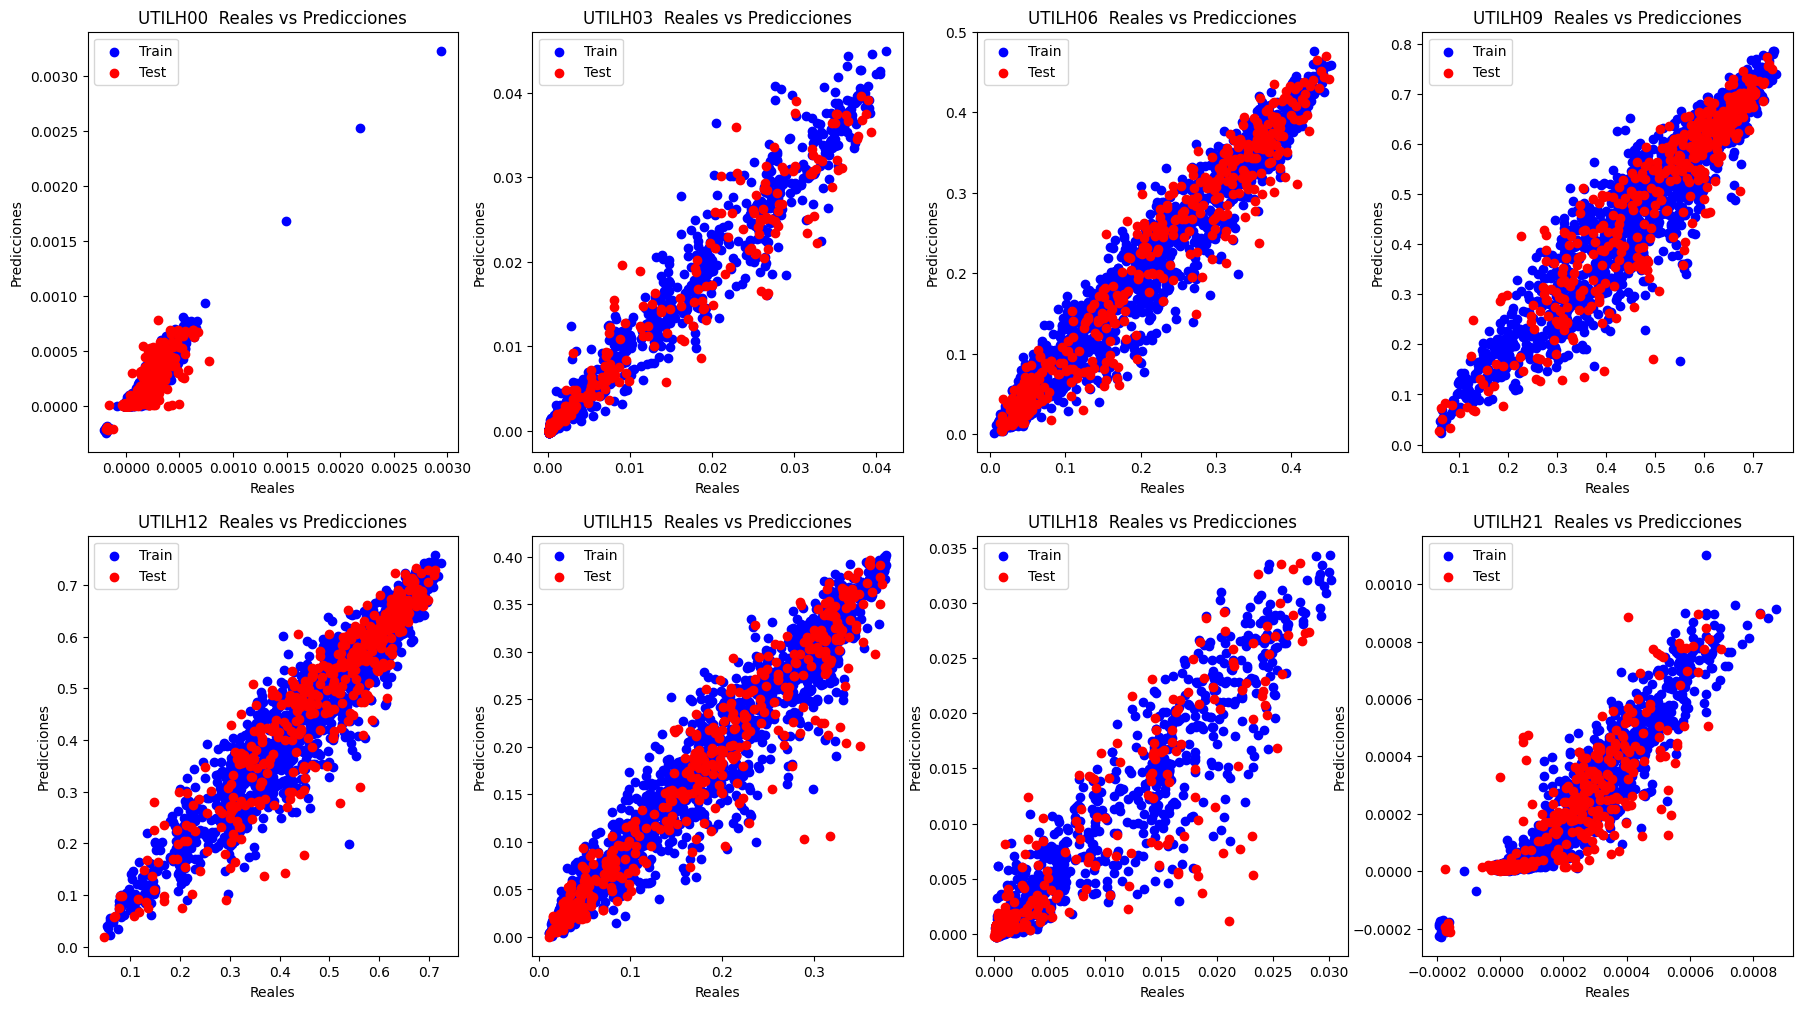

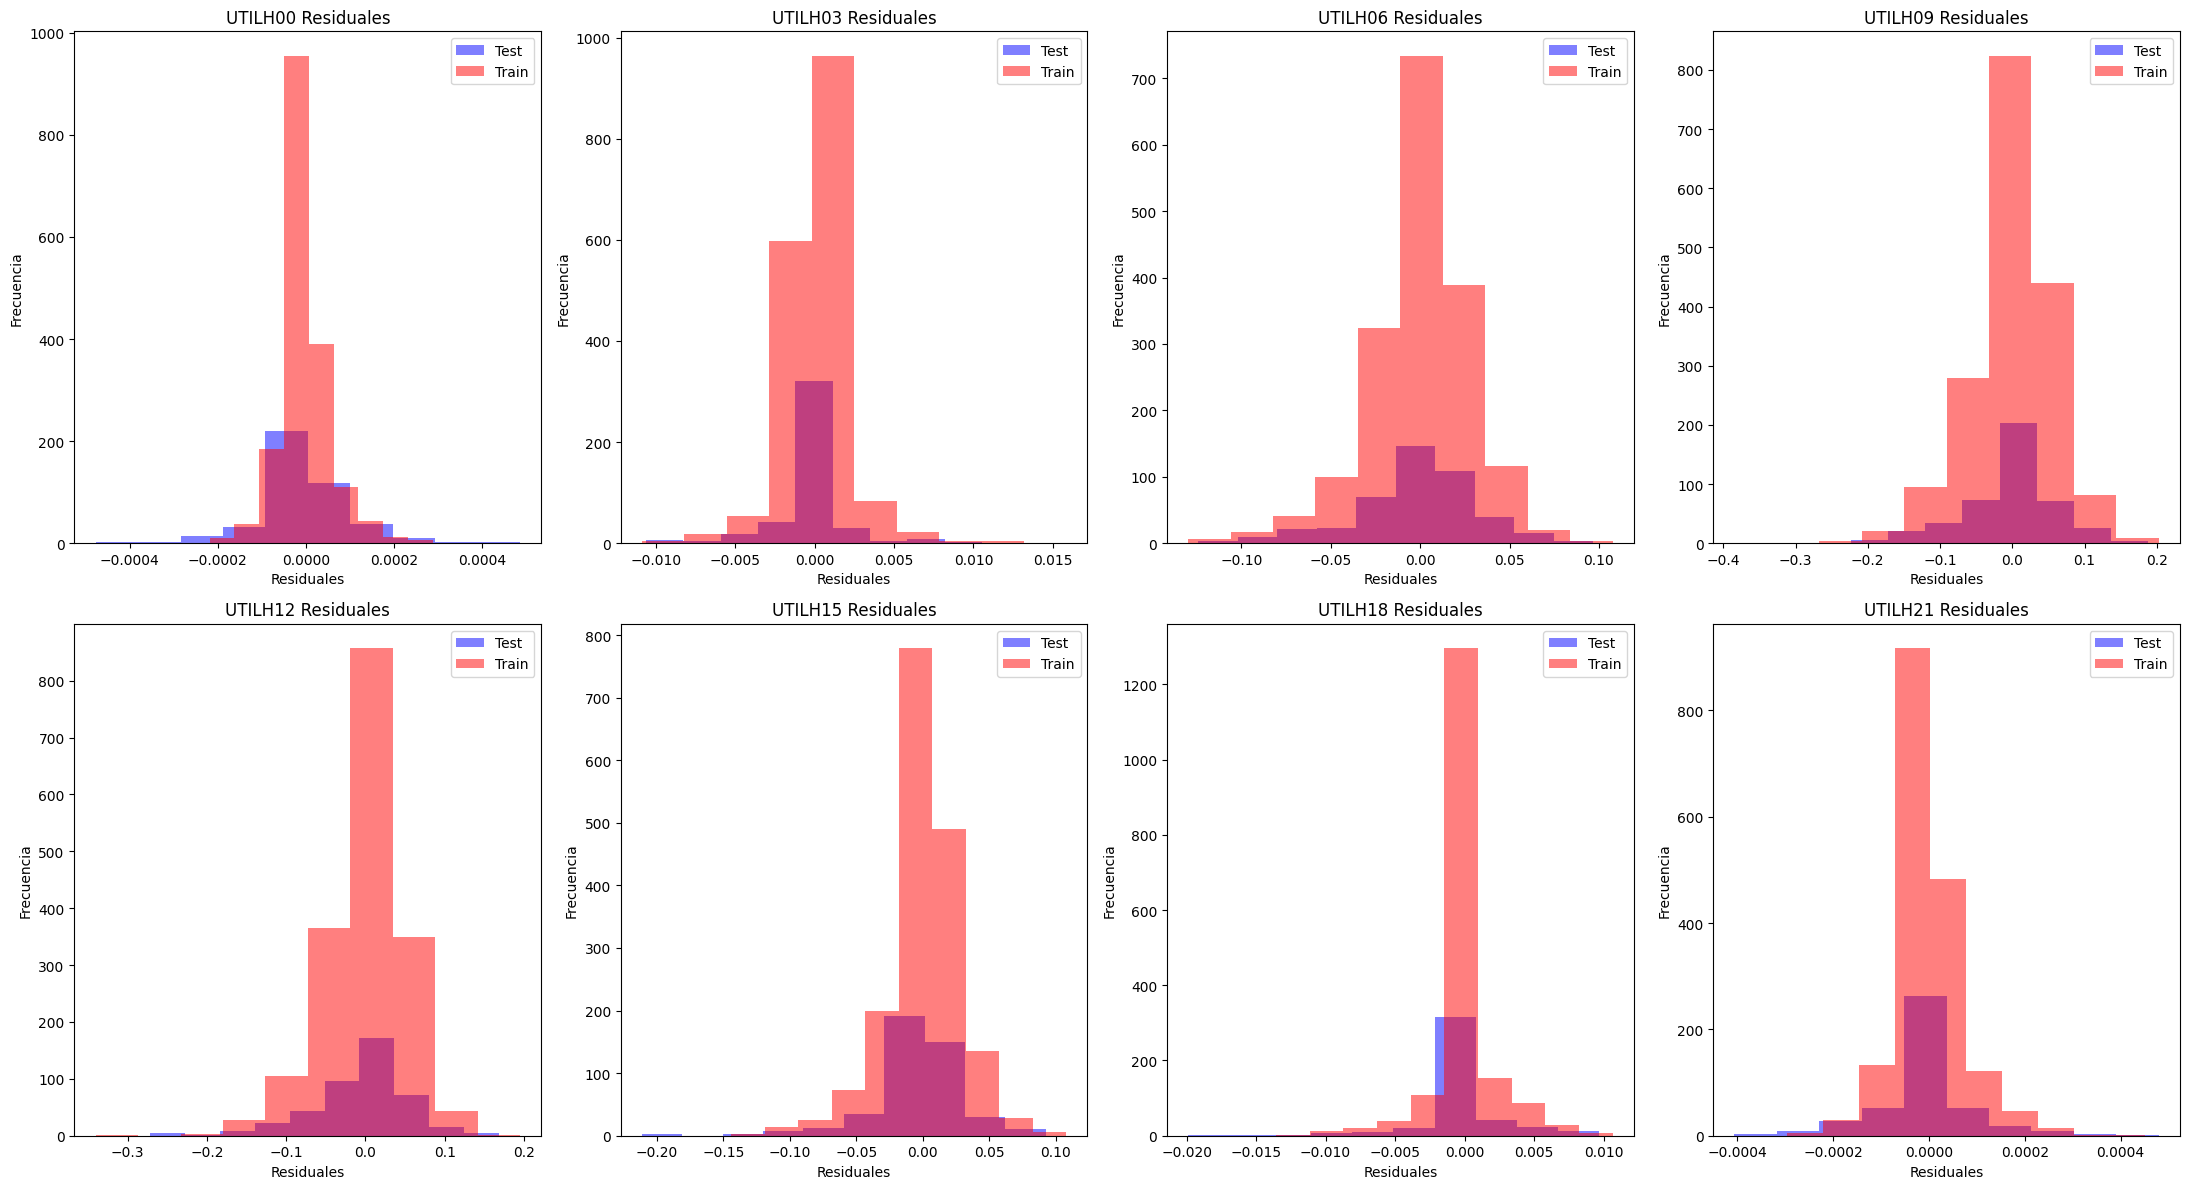

In [20]:
# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1,0.05],
    'max_depth': [3, 5,None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
fig2, axs2 = plt.subplots(2, 4, figsize=(22, 12))
fig, axs = plt.subplots(2, 4, figsize=(22, 12))
i=0

# Create an empty DataFrame to store results
results_df_gb_tuned = pd.DataFrame(columns=['OUTPUT', 'RMSE_train', 'R_squared_train', 'RMSE_test', 'R_squared_test', 'Best_Params'])

for OUTPUT in OUTPUTS:

    y = df[OUTPUT]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,  # percentage of test data
                                                        random_state=1234)   # Preserves distribution of y

    # Create Gradient Boosting Regressor
    gb = GradientBoostingRegressor(random_state=1234)

    # Perform Grid Search to find best parameters
    grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_gb = grid_search.best_estimator_

    # Predict on the training set
    y_train_pred = best_gb.predict(X_train)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # Calculate R-squared
    r2_train = r2_score(y_train, y_train_pred)

    # Predict on the test set
    y_test_pred = best_gb.predict(X_test)
    # Calculate RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # Calculate R-squared
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results to DataFrame
    results_df_gb_tuned = results_df_gb_tuned.append({'OUTPUT': OUTPUT,
                                                      'RMSE_train': rmse_train,
                                                      'R_squared_train': r2_train,
                                                      'RMSE_test': rmse_test,
                                                      'R_squared_test': r2_test,
                                                      'Best_Params': grid_search.best_params_}, ignore_index=True)
    row_index = i // 4
    col_index = i % 4
    # Plotting
    axs2[row_index, col_index].scatter(y_train_pred, y_train, color='blue', label='Train')
    axs2[row_index, col_index].scatter(y_test_pred, y_test, color='red', label='Test')
    axs2[row_index, col_index].set_title(f'{OUTPUT}  Reales vs Predicciones')
    axs2[row_index, col_index].set_xlabel('Reales')
    axs2[row_index, col_index].set_ylabel('Predicciones')
    axs2[row_index, col_index].legend()

       # Calculate residuals
    residuals_test = y_test - y_test_pred
    residuals_train = y_train - y_train_pred
    # Plot residuals
    axs[row_index, col_index].hist(residuals_test, color='blue', alpha=0.5, label='Test')
    axs[row_index, col_index].hist(residuals_train, color='red', alpha=0.5, label='Train')
    axs[row_index, col_index].set_title(f"{OUTPUT} Residuales")
    axs[row_index, col_index].set_xlabel('Residuales')
    axs[row_index, col_index].set_ylabel('Frecuencia')
    axs[row_index, col_index].legend()
    i+=1

# Print the results DataFrame
plt.tight_layout()
plt.show()



In [37]:
results_df_gb_tuned.head(8)

,OUTPUT,RMSE_train,R_squared_train,RMSE_test,R_squared_test,Best_Params
0,UTILH00,0.000055,0.931921,0.000103,0.729222,"{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}"
1,UTILH03,0.001903,0.971606,0.002413,0.952519,"{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}"
2,UTILH06,0.028387,0.954413,0.033646,0.939182,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}"
3,UTILH09,0.056639,0.890496,0.065322,0.859854,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}"
4,UTILH12,0.049302,0.908663,0.061335,0.863688,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}"
5,UTILH15,0.028495,0.939443,0.033956,0.913529,"{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}"
6,UTILH18,0.002273,0.921883,0.003327,0.832779,"{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}"
7,UTILH21,0.000068,0.906368,0.000103,0.766651,"{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}"


# 5. Stacking

Hacemos stacking de los 3 algoritmos, usando los mejores parámetros que hemos descubierto anteriormente

In [33]:
dfs = {'GradientBoost': results_df_gb_tuned, 'RandomForest': results_df_rf_tuned, 'BaggingTrees': results_df_bagged}
results_stacking = pd.DataFrame(columns=['OUTPUT', 'RMSE_train', 'R_squared_train', 'RMSE_test', 'R_squared_test'])

algo_models = {}

for algo, dfr in dfs.items():
    for index, row in dfr.iterrows():
        model_params = row['Best_Params']
        output =  row['OUTPUT']
        if algo == 'GradientBoost':
            model = GradientBoostingRegressor(**model_params)
        elif algo == 'RandomForest':
            model = RandomForestRegressor(**model_params)
        elif algo == 'BaggingTrees':
            model = BaggingRegressor(**model_params)
        if output in algo_models:
            algo_models[output].append((f'{algo}_{output}', model))

        else:
            algo_models[output] = [(f'{algo}_{output}', model)]
        

for OUTPUT in OUTPUTS:
    y = df[OUTPUT]
    base_estimators = algo_models[OUTPUT]
    stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=LinearRegression())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    stacking_regressor.fit(X_train, y_train)

    y_train_pred = stacking_regressor.predict(X_train)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # Calculate R-squared
    r2_train = r2_score(y_train, y_train_pred)

    # Predict on the test set
    y_test_pred = stacking_regressor.predict(X_test)
    # Calculate RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # Calculate R-squared
    r2_test = r2_score(y_test, y_test_pred)
    # Append results to DataFrame
    results_stacking= results_stacking.append({'OUTPUT': OUTPUT,
                                                      'RMSE_train': rmse_train,
                                                      'R_squared_train': r2_train,
                                                      'RMSE_test': rmse_test,
                                                      'R_squared_test': r2_test}, ignore_index=True)

In [34]:
results_stacking.head(8)

,OUTPUT,RMSE_train,R_squared_train,RMSE_test,R_squared_test
0,UTILH00,0.000069,0.883689,0.000170,0.483947
1,UTILH03,0.001684,0.977975,0.002296,0.955064
2,UTILH06,0.026712,0.960298,0.032724,0.938475
3,UTILH09,0.046793,0.923824,0.066084,0.865557
4,UTILH12,0.041197,0.935329,0.059138,0.879556
5,UTILH15,0.025592,0.950885,0.032671,0.921654
6,UTILH18,0.002002,0.937976,0.002936,0.880626
7,UTILH21,0.000035,0.974735,0.000103,0.779799


## 6. Comparison

In [40]:
merged_df = results_df_gb_tuned.merge(results_df_rf_tuned, on='OUTPUT', suffixes=('_GradientBoosting', '_RandomForest')) \
    .merge(results_df_bagged, on='OUTPUT', suffixes=('', '_BaggedTrees')) \
    .merge(results_df_lr, on='OUTPUT', suffixes=('', '_LinearRegression')) \
     .merge(results_stacking, on='OUTPUT', suffixes=('', '_Stacking'))

merged_df.rename(columns={'RMSE_train': 'RMSE_train_BaggedTrees', 'RMSE_test': 'RMSE_test_BaggedTrees'}, inplace=True)


In [41]:
merged_df_train = merged_df[['OUTPUT', 
                       'RMSE_train_GradientBoosting',
                       'RMSE_train_RandomForest', 
                       'RMSE_train_BaggedTrees', 
                       'RMSE_train_LinearRegression',
                       'RMSE_train_Stacking']]
# Set the OUTPUT column as index
merged_df_train.set_index('OUTPUT', inplace=True)

In [43]:
merged_df_train = merged_df[['OUTPUT', 
                       'RMSE_train_GradientBoosting',
                       'RMSE_train_RandomForest', 
                       'RMSE_train_BaggedTrees', 
                       'RMSE_train_LinearRegression',
                       'RMSE_train_Stacking']]
# Set the OUTPUT column as index
merged_df_train.set_index('OUTPUT', inplace=True)

In [44]:
merged_df_test = merged_df[['OUTPUT', 
                       'RMSE_test_GradientBoosting',
                       'RMSE_test_RandomForest', 
                       'RMSE_test_BaggedTrees', 
                       'RMSE_test_LinearRegression',
                       'RMSE_test_Stacking']]
# Set the OUTPUT column as index
merged_df_test.set_index('OUTPUT', inplace=True)

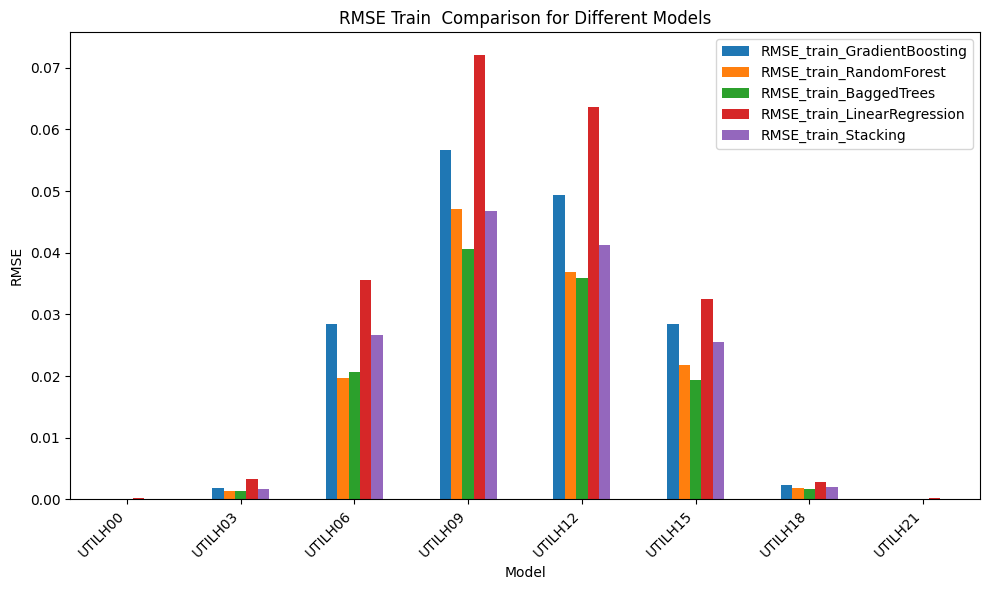

In [45]:


# Plot bar plot
merged_df_train.plot(kind='bar', figsize=(10, 6))
plt.title('RMSE Train  Comparison for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


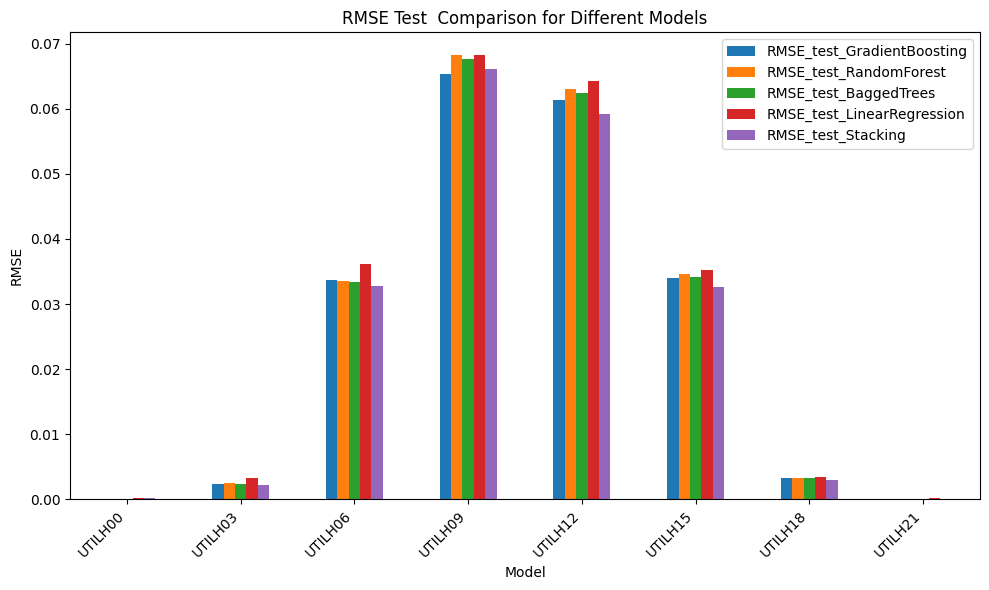

In [46]:


# Plot bar plot
merged_df_test.plot(kind='bar', figsize=(10, 6))
plt.title('RMSE Test  Comparison for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()